In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [17]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 28, 28])

In [3]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

In [5]:
from torch import nn
from jcopdl.layers import linear_block

class customNeuralNetwork(nn.Module):
    def __init__(self, input_Size, n_neuron, output, activation='relu', activation_output='lsoftmax', batch_norm=False, drop=0.2):
        super().__init__()
        if type(n_neuron) != list:
            n_neuron = list(n_neuron)
        all_neuron=[input_Size]+n_neuron+[output]
        seq = [nn.Flatten()]
        for i in range(len(all_neuron)-1):
            if i != len(all_neuron)-2:
                seq.append(linear_block(all_neuron[i], all_neuron[i+1], activation=activation, dropout=drop, batch_norm=batch_norm))
            else:
                seq.append(linear_block(all_neuron[i], all_neuron[i+1], activation=activation_output, batch_norm=batch_norm))

        #try:
        #    seq = [linear_block(all_neuron[i], all_neuron[i+1], activation=activation, dropout=drop, batch_norm=batch_norm) for i in range(len(all_neuron)-1)]
        #except Exception as e:
        #    print(e)
        #print(seq)
        self.fc = nn.Sequential(
            *seq
        )
    def forward(self, x):
        return self.fc(x)

In [6]:
config = set_config({
    "input_size": 784,
    "neuron": (256,128,64),
    "output_size": len(train_set.classes),
    "dropout": 0.2,
    "activation_output":'lsoftmax'
})

# Training Preparation -> MCOC

In [9]:
model = customNeuralNetwork(
    input_Size=config.input_size,
    n_neuron=config.neuron,
    output=config.output_size,
    activation='tanh',
    activation_output='lsoftmax',
    batch_norm=False, drop=0.2
).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

In [10]:
model

customNeuralNetwork(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=10, bias=True)
      (1): LogSoftmax(dim=1)
    )
  )
)

# Training

In [11]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6934 | Test_cost  = 0.4536 | Train_score = 0.7620 | Test_score = 0.8338 |




Epoch     2
Train_cost  = 0.4614 | Test_cost  = 0.4159 | Train_score = 0.8369 | Test_score = 0.8507 |




Epoch     3
Train_cost  = 0.4268 | Test_cost  = 0.3910 | Train_score = 0.8482 | Test_score = 0.8592 |




Epoch     4
Train_cost  = 0.4044 | Test_cost  = 0.4078 | Train_score = 0.8560 | Test_score = 0.8497 |
==> EarlyStop patience =  1 | Best test_score: 0.8592




Epoch     5
Train_cost  = 0.3845 | Test_cost  = 0.3783 | Train_score = 0.8626 | Test_score = 0.8666 |




Epoch     6
Train_cost  = 0.3717 | Test_cost  = 0.3837 | Train_score = 0.8670 | Test_score = 0.8601 |
==> EarlyStop patience =  1 | Best test_score: 0.8666




Epoch     7
Train_cost  = 0.3644 | Test_cost  = 0.3533 | Train_score = 0.8690 | Test_score = 0.8739 |




Epoch     8
Train_cost  = 0.3512 | Test_cost  = 0.3469 | Train_score = 0.8743 | Test_score = 0.8724 |
==> EarlyStop patience =  1 | Best test_score: 0.8739




Epoch     9
Train_cost  = 0.3464 | Test_cost  = 0.3481 | Train_score = 0.8764 | Test_score = 0.8748 |




Epoch    10
Train_cost  = 0.3369 | Test_cost  = 0.3732 | Train_score = 0.8799 | Test_score = 0.8619 |
==> EarlyStop patience =  1 | Best test_score: 0.8748




Epoch    11
Train_cost  = 0.3326 | Test_cost  = 0.3524 | Train_score = 0.8802 | Test_score = 0.8713 |
==> EarlyStop patience =  2 | Best test_score: 0.8748




Epoch    12
Train_cost  = 0.3252 | Test_cost  = 0.3373 | Train_score = 0.8835 | Test_score = 0.8800 |




Epoch    13
Train_cost  = 0.3209 | Test_cost  = 0.3453 | Train_score = 0.8838 | Test_score = 0.8770 |
==> EarlyStop patience =  1 | Best test_score: 0.8800




Epoch    14
Train_cost  = 0.3164 | Test_cost  = 0.3235 | Train_score = 0.8862 | Test_score = 0.8837 |




Epoch    15
Train_cost  = 0.3104 | Test_cost  = 0.3299 | Train_score = 0.8881 | Test_score = 0.8814 |
==> EarlyStop patience =  1 | Best test_score: 0.8837




Epoch    16
Train_cost  = 0.3048 | Test_cost  = 0.3423 | Train_score = 0.8903 | Test_score = 0.8818 |
==> EarlyStop patience =  2 | Best test_score: 0.8837




Epoch    17
Train_cost  = 0.3020 | Test_cost  = 0.3250 | Train_score = 0.8916 | Test_score = 0.8861 |




Epoch    18
Train_cost  = 0.2982 | Test_cost  = 0.3201 | Train_score = 0.8925 | Test_score = 0.8871 |




Epoch    19
Train_cost  = 0.2950 | Test_cost  = 0.3265 | Train_score = 0.8920 | Test_score = 0.8850 |
==> EarlyStop patience =  1 | Best test_score: 0.8871




Epoch    20
Train_cost  = 0.2876 | Test_cost  = 0.3236 | Train_score = 0.8964 | Test_score = 0.8847 |


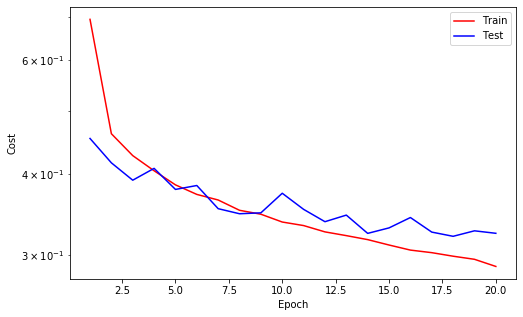

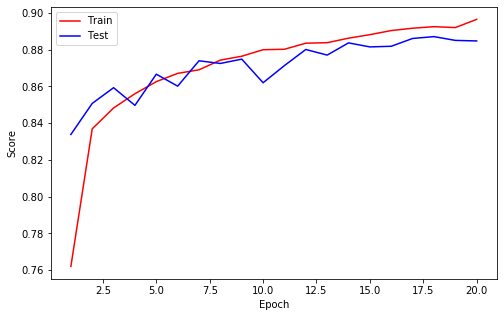

==> EarlyStop patience =  2 | Best test_score: 0.8871




Epoch    21
Train_cost  = 0.2852 | Test_cost  = 0.3152 | Train_score = 0.8988 | Test_score = 0.8877 |




Epoch    22
Train_cost  = 0.2798 | Test_cost  = 0.3236 | Train_score = 0.8979 | Test_score = 0.8846 |
==> EarlyStop patience =  1 | Best test_score: 0.8877




Epoch    23
Train_cost  = 0.2779 | Test_cost  = 0.3265 | Train_score = 0.8998 | Test_score = 0.8852 |
==> EarlyStop patience =  2 | Best test_score: 0.8877




Epoch    24
Train_cost  = 0.2763 | Test_cost  = 0.3213 | Train_score = 0.9015 | Test_score = 0.8849 |
==> EarlyStop patience =  3 | Best test_score: 0.8877




Epoch    25
Train_cost  = 0.2742 | Test_cost  = 0.3258 | Train_score = 0.9012 | Test_score = 0.8865 |
==> EarlyStop patience =  4 | Best test_score: 0.8877




Epoch    26
Train_cost  = 0.2638 | Test_cost  = 0.3156 | Train_score = 0.9025 | Test_score = 0.8901 |




Epoch    27
Train_cost  = 0.2652 | Test_cost  = 0.3225 | Train_score = 0.9028 | Test_score = 0.8870 |
==> EarlyStop patience =  1 | Best test_score: 0.8901




Epoch    28
Train_cost  = 0.2675 | Test_cost  = 0.3243 | Train_score = 0.9030 | Test_score = 0.8851 |
==> EarlyStop patience =  2 | Best test_score: 0.8901




Epoch    29
Train_cost  = 0.2575 | Test_cost  = 0.3245 | Train_score = 0.9076 | Test_score = 0.8867 |
==> EarlyStop patience =  3 | Best test_score: 0.8901




Epoch    30
Train_cost  = 0.2563 | Test_cost  = 0.3235 | Train_score = 0.9073 | Test_score = 0.8888 |
==> EarlyStop patience =  4 | Best test_score: 0.8901




Epoch    31
Train_cost  = 0.2563 | Test_cost  = 0.3187 | Train_score = 0.9069 | Test_score = 0.8883 |
==> EarlyStop patience =  5 | Best test_score: 0.8901
==> Execute Early Stopping at epoch: 31 | Best test_score: 0.8901
==> Best model is saved at model


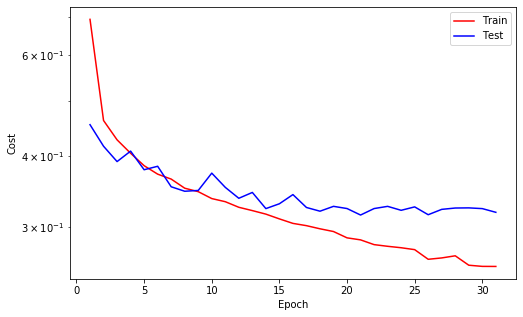

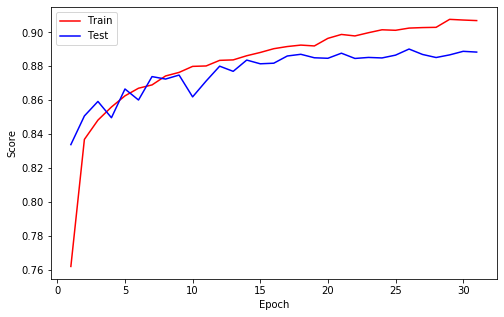

In [12]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

### Load Best Model

In [14]:
# weights = torch.load("model/weights_best.pth", map_location="cpu")
# config = torch.load("model/configs.pth", map_location="cpu")

# model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
# model.load_state_dict(weights)
# model = model.to(device)

# Visualisasi

In [20]:
import matplotlib.pyplot as plt

# Predict

In [21]:
feature, target = next(iter(testloader))

feature, target = feature.to(device), target.to(device)
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['Sandal',
 'Shirt',
 'Shirt',
 'Shirt',
 'Sandal',
 'Dress',
 'Pullover',
 'Sneaker',
 'Dress',
 'Sandal',
 'Pullover',
 'Dress',
 'Trouser',
 'Pullover',
 'Coat',
 'Pullover',
 'T-shirt or Top',
 'Sneaker',
 'Sneaker',
 'Bag',
 'Dress',
 'Shirt',
 'Coat',
 'Trouser',
 'Trouser',
 'Coat',
 'Dress',
 'Sneaker',
 'Shirt',
 'Pullover',
 'Coat',
 'Dress',
 'Ankle boot',
 'Ankle boot',
 'Trouser',
 'Coat',
 'Sandal',
 'Sneaker',
 'Shirt',
 'Sandal',
 'Pullover',
 'Sandal',
 'Coat',
 'T-shirt or Top',
 'T-shirt or Top',
 'Bag',
 'Coat',
 'Ankle boot',
 'Coat',
 'Ankle boot',
 'Sandal',
 'T-shirt or Top',
 'Sandal',
 'Sneaker',
 'Trouser',
 'Coat',
 'Sneaker',
 'Ankle boot',
 'Coat',
 'Bag',
 'Sandal',
 'Ankle boot',
 'T-shirt or Top',
 'Bag',
 'Sneaker',
 'Trouser',
 'Dress',
 'Pullover',
 'Coat',
 'Trouser',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Bag',
 'Trouser',
 'Shirt',
 'Trouser',
 'Dress',
 'Shirt',
 'Sneaker',
 'Sneaker',
 'Dress',
 'Coat',
 'Bag',
 'Shirt',
 'Bag',
 'Sandal',
 'Ankl

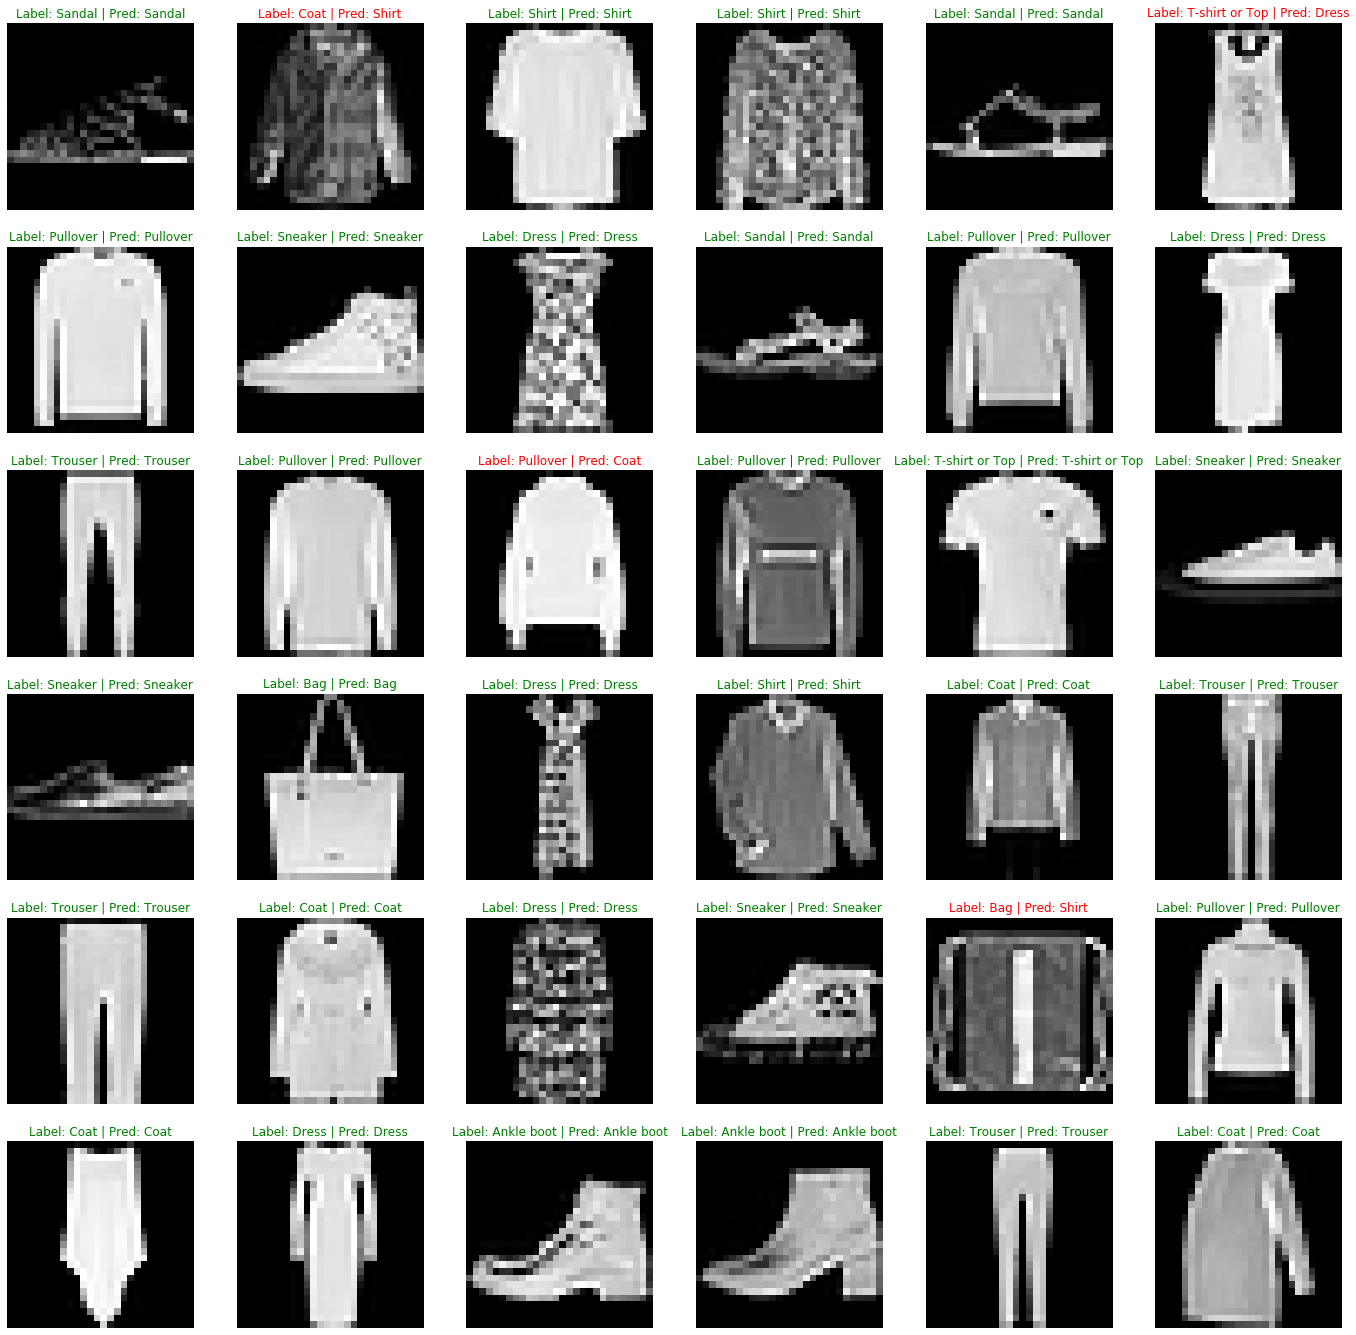

In [22]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
    ax.axis('off');